# Libraries 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18,8)},style='darkgrid')
sns.set_palette('viridis')
from time import time
import re
import string
from nltk.corpus import stopwords
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

# Collect Data

In [2]:
df = pd.read_csv(r"E:\Data Science\Datasets\Spam SMS Detection\spam.csv",encoding='iso-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Data Preprocessing

In [3]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)
df.rename(columns={'v1':'spam','v2':'mail'},inplace=True)

In [4]:
df.head()

,spam,mail
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   spam    5572 non-null   object
 1   mail    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
df.duplicated().sum()

403

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.duplicated().sum()

0

In [9]:
df['spam']=df['spam'].apply(lambda x: 1 if x=='spam' else 0)
df = df[['mail','spam']].reset_index(drop=True)
df.head()

,mail,spam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [10]:
#Remove numbers from mail
df['mail'] = df['mail'].apply(lambda text : re.sub(f'[{string.digits}]','',text))

In [11]:
df.head()

,mail,spam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in a wkly comp to win FA Cup final...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [12]:
#Get the length of each mail
df['word_len'] = df['mail'].apply(len)

In [13]:
df.duplicated().sum()

20

In [14]:
df.drop_duplicates(inplace=True)

In [15]:
df.duplicated().sum()

0

# EDA 

In [16]:
#Summary statistics
df.describe()[['word_len']].T

,count,mean,std,min,25%,50%,75%,max
word_len,5149.0,76.638376,56.246496,0.0,36.0,60.0,113.0,910.0


In [17]:
#Drop empty mails
df[df['word_len']==2]

,mail,spam,word_len
1858,Ok,0,2


In [18]:
df.drop(index=1560,inplace=True)

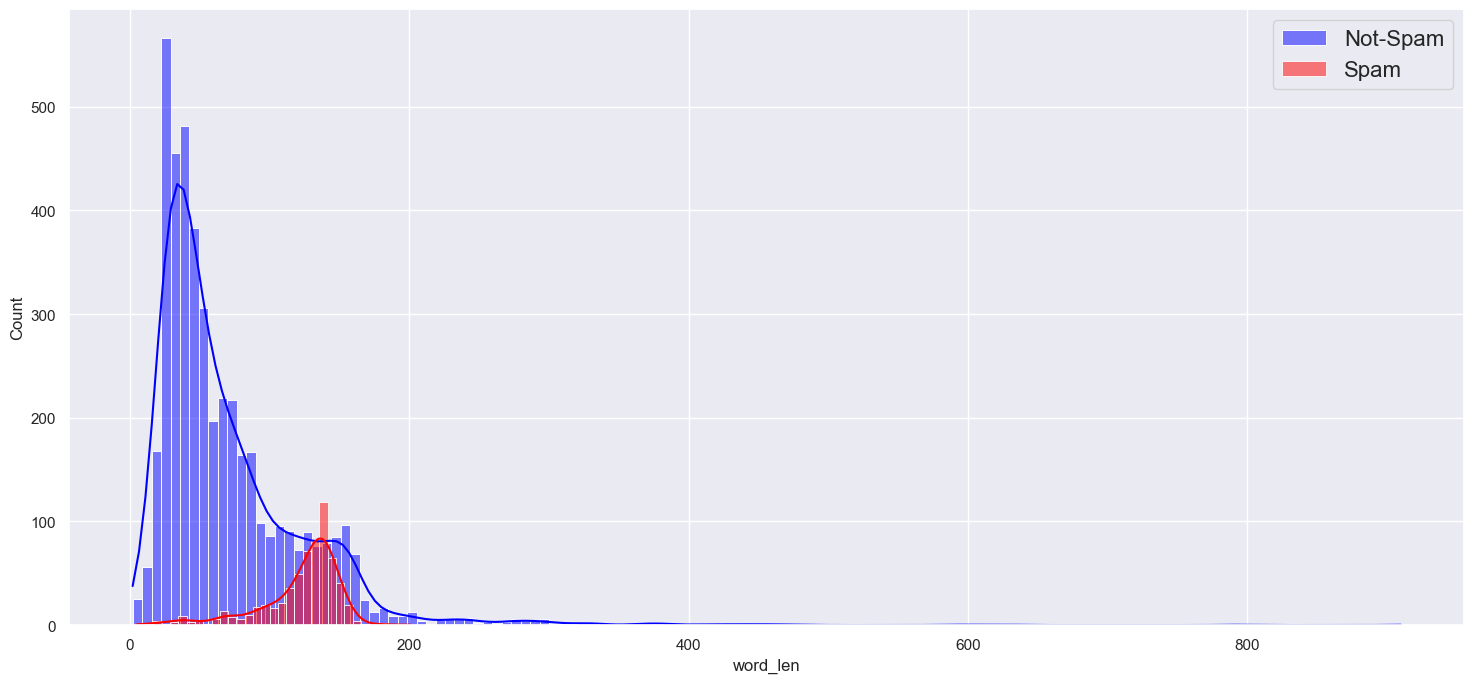

In [19]:
#Show the distribution of words length in spams and not-spams 
sns.histplot(df[df['spam']==0]['word_len'],color='blue',label='Not-Spam',kde=True)
sns.histplot(df[df['spam']==1]['word_len'],color='red',label='Spam',kde=True)
plt.legend(fontsize=16)
plt.show()

##### We conclude that the length of words in normal mails is higher than spam mails

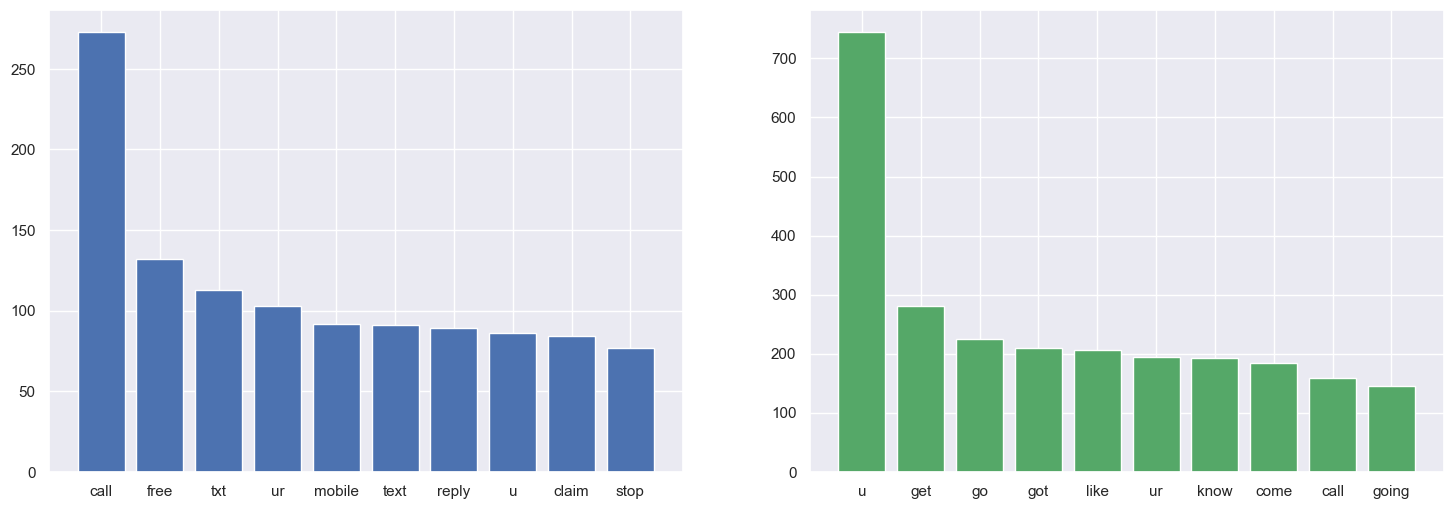

In [20]:
#The top 10 words appears in spams and not-spams mails
stop_words = stopwords.words('english')
spam_words=Counter([word.lower() for word in ''.join(df[df['spam']==1]['mail']).split() if (word.lower().isalpha()) and (word.lower() not in stop_words) and (word.lower() not in string.punctuation)])
notspam_words =Counter([word.lower() for word in ''.join(df[df['spam']==0]['mail']).split() if (word.lower().isalpha()) and (word.lower() not in stop_words) and (word.lower() not in string.punctuation)])
#----------------------------
fig,axs = plt.subplots(1,2,figsize=(18,6))
axs[0].bar(*zip(*spam_words.most_common(10)), color='b')
axs[1].bar(*zip(*notspam_words.most_common(10)), color='g')
plt.show()

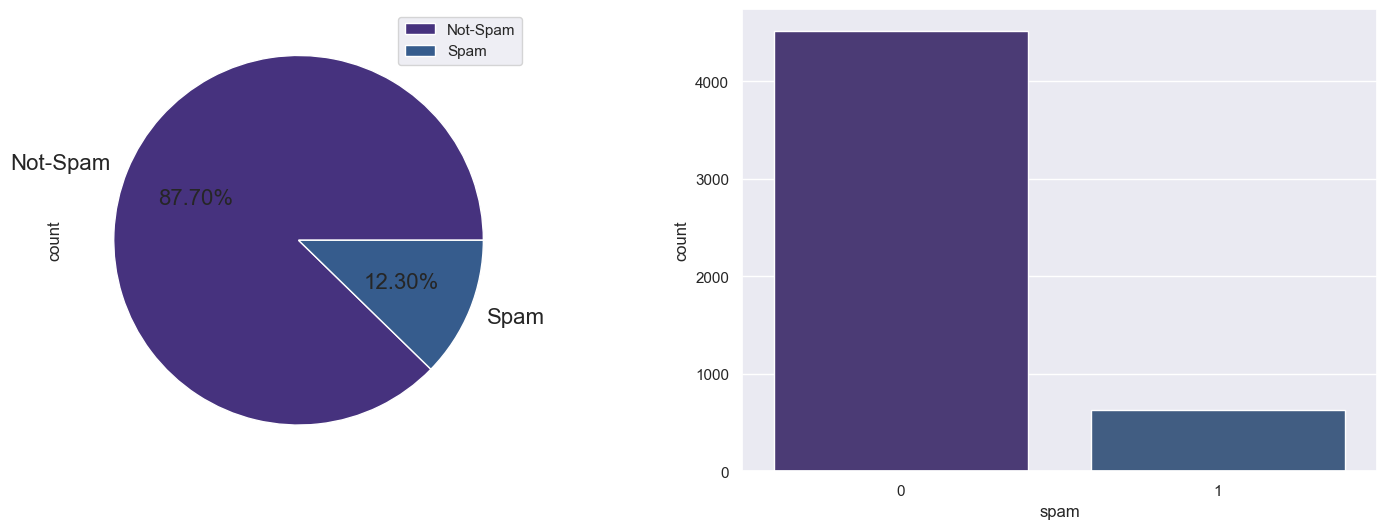

In [21]:
#Discover the balance between spam and not-spam mails
fig,axs = plt.subplots(1,2,figsize=(18,6))
df['spam'].value_counts().plot(kind='pie',labels=['Not-Spam','Spam'],
                               autopct='%.2f%%',fontsize=16,legend=True,ax=axs[0])
sns.countplot(data=df,x='spam',ax=axs[1])
plt.show()

# Model Buliding

#### We will evaluate our models through balanced and imbalanced data just to see the effect on models but we know that : 
- Balancing the data helps mitigate the impact of class imbalance, where one class has significantly fewer instances than the other.Imbalanced data can lead to models being biased towards the majority class making it difficult for the model to properly learn patterns in the minority class.
- Some algorithms like decision trees can handle imbalanced data well, while others like linear classifiers may benefit more from balanced datasets. 

In [48]:
#Split data to train and test
x_train,x_test,y_train,y_test = train_test_split(df['mail'],df['spam'],test_size=0.3,random_state=10)

In [37]:
models = {'LogisticRegression':LogisticRegression(random_state=10),
         'NaiveBayes':MultinomialNB(),
         'SVC':SVC(random_state=10,probability=True)}

In [38]:
def evl_model(xtrain,ytrain,xtest,ytest):
    sns.set(rc={'figure.figsize':(18,6)})
    i=0
    for name,model in models.items():
        fig,axs=plt.subplots(1,2)
        print('Model : '+name)
        print('_'*30)
        start=time()
        model.fit(xtrain,ytrain)
        y_pred = model.predict(xtest)
        end=time()
        #AUC-ROC Curve
        y_proba = model.predict_proba(xtest)
        fpr, tpr, _ = roc_curve(ytest, y_proba[:, 1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[i])
        axs[i].plot([0, 1], [0, 1], color = 'y')
        #Confusion Matrix
        cm = confusion_matrix(ytest,y_pred,labels=model.classes_)
        cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
        cmd.plot(colorbar=False,ax=axs[i+1],cmap='magma')
        axs[i+1].grid(False)
        plt.tight_layout()
        plt.show()
        #Scores
        print(f'Recall Score: ',recall_score(ytest,y_pred).round(3))
        print('Precision: ',precision_score(ytest,y_pred).round(3))
        print('F1-Score: ',f1_score(ytest,y_pred).round(3))
        print('Accuracy Score: ',accuracy_score(ytest,y_pred).round(3))
        print('AUC Score: ',roc_auc_score(ytest,y_proba[:,1]).round(3))
        print('Running Time : ',round((end-start)/60.0,2),'Mins')
        print('*'*30)

In [39]:
# Imbalanced data
tfidf_vectorizer = TfidfVectorizer(lowercase=True, #Lowercase chars
                                   ngram_range=(1,1), #Capture only single words in each text(unigrams)
                                   stop_words='english',#Remove stop_words
                                   min_df=2)#Ignore words that appears less than 2 times
x_train_vec = tfidf_vectorizer.fit_transform(x_train)
x_test_vec = tfidf_vectorizer.transform(x_test)

Model : LogisticRegression
______________________________


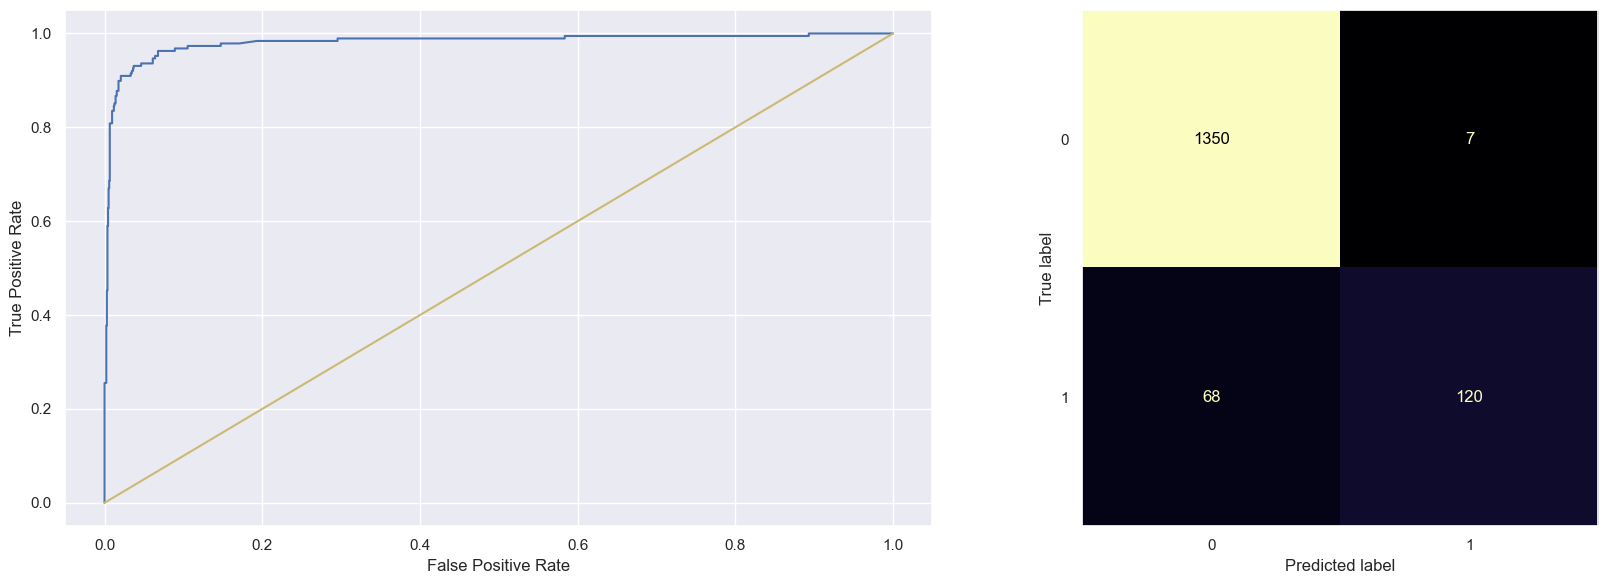

Recall Score:  0.638
Precision:  0.945
F1-Score:  0.762
Accuracy Score:  0.951
AUC Score:  0.981
Running Time :  0.0 Mins
******************************
Model : NaiveBayes
______________________________


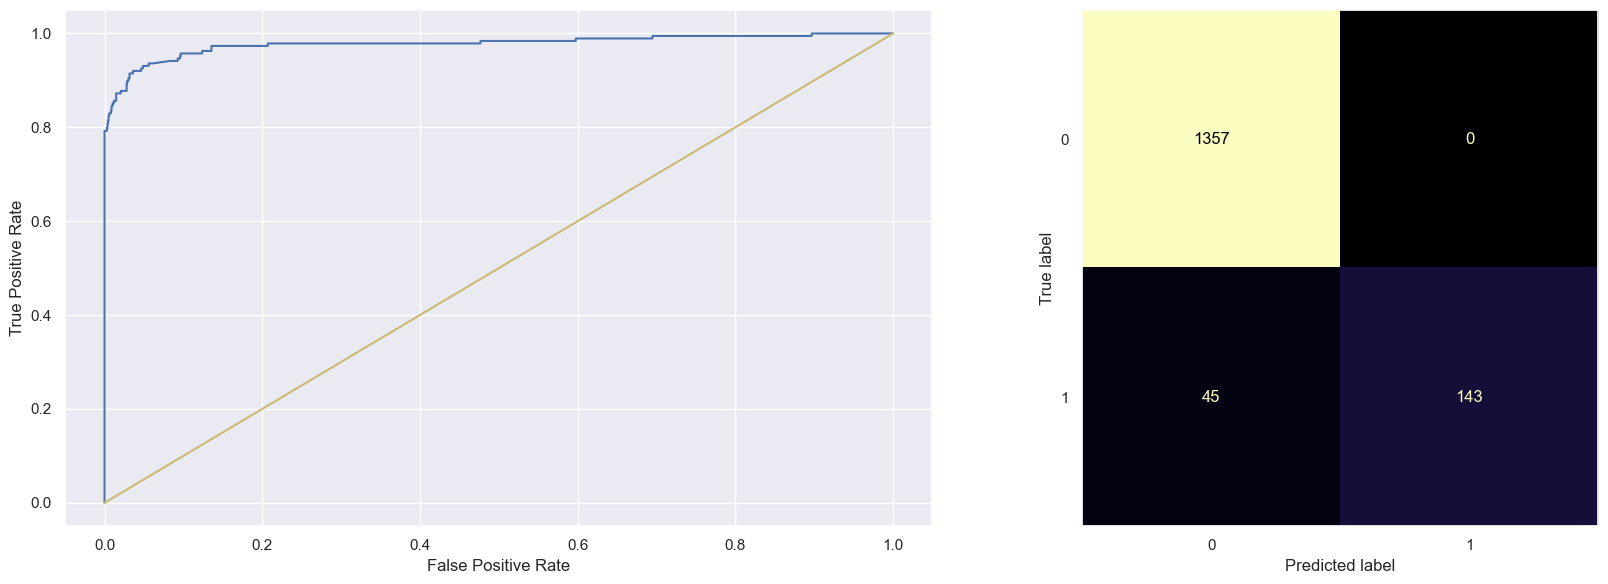

Recall Score:  0.761
Precision:  1.0
F1-Score:  0.864
Accuracy Score:  0.971
AUC Score:  0.978
Running Time :  0.0 Mins
******************************
Model : SVC
______________________________


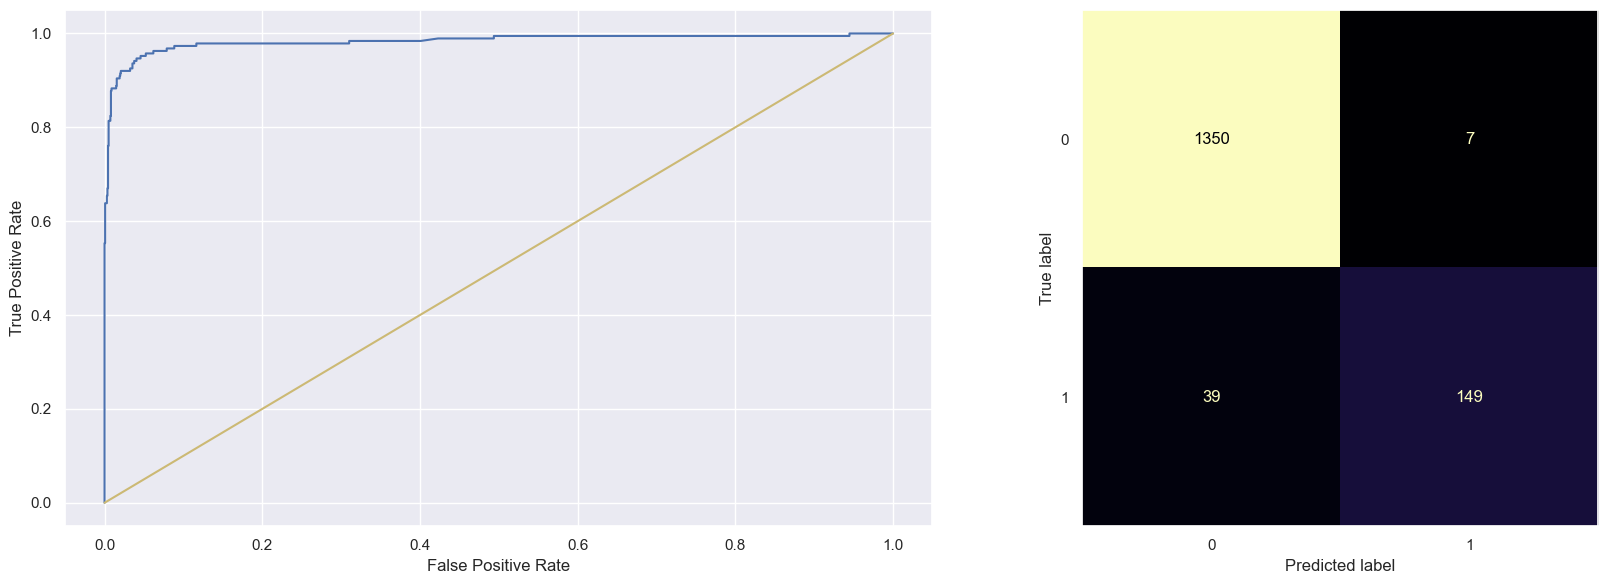

Recall Score:  0.793
Precision:  0.955
F1-Score:  0.866
Accuracy Score:  0.97
AUC Score:  0.983
Running Time :  0.06 Mins
******************************


In [40]:
evl_model(x_train_vec,y_train,x_test_vec,y_test)

In [49]:
#Balanced Data
sampler = RandomOverSampler(random_state=10)
x_train,y_train = sampler.fit_resample(np.array(x_train).reshape(-1,1),y_train)

tfidf_vectorizer = TfidfVectorizer(lowercase=True,ngram_range=(1,1),stop_words='english',min_df=2)
# Handling dimensions for tfidf_vectorizer
x_train = pd.Series(x_train.flatten())
x_train = tfidf_vectorizer.fit_transform(x_train)
x_test = tfidf_vectorizer.transform(x_test)

<Axes: xlabel='spam'>

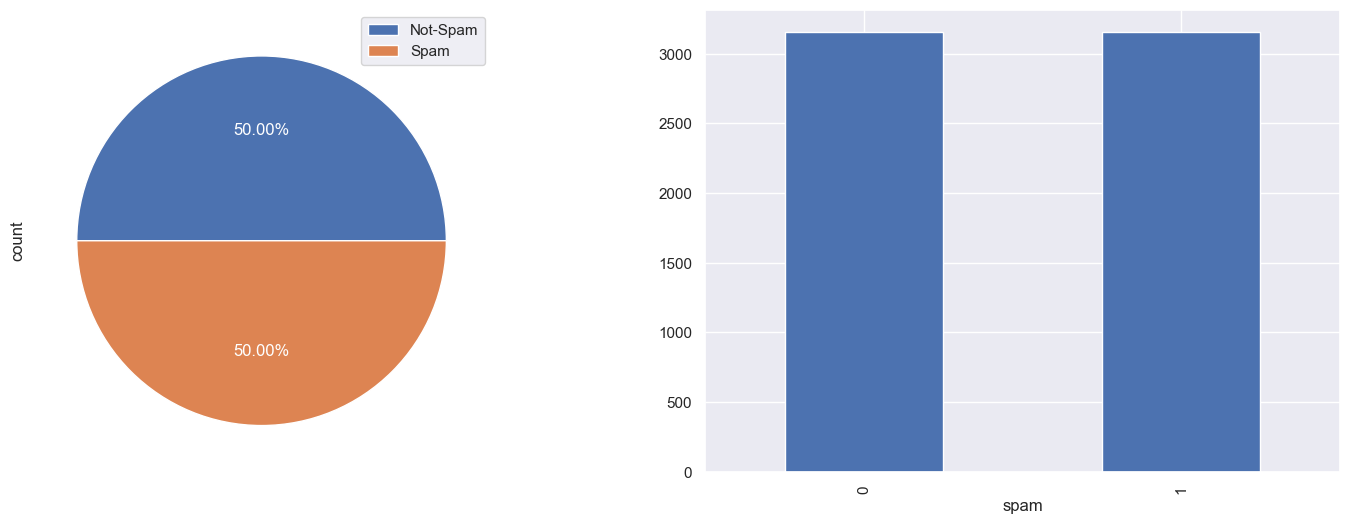

In [50]:
fig,axs = plt.subplots(1,2,figsize=(18,6))
y_train.value_counts().plot(kind='pie',autopct='%.2f%%',textprops={'color':'white'},labels=['Not-Spam','Spam'],legend=True,ax=axs[0])
y_train.value_counts().plot(kind='bar')

Model : LogisticRegression
______________________________


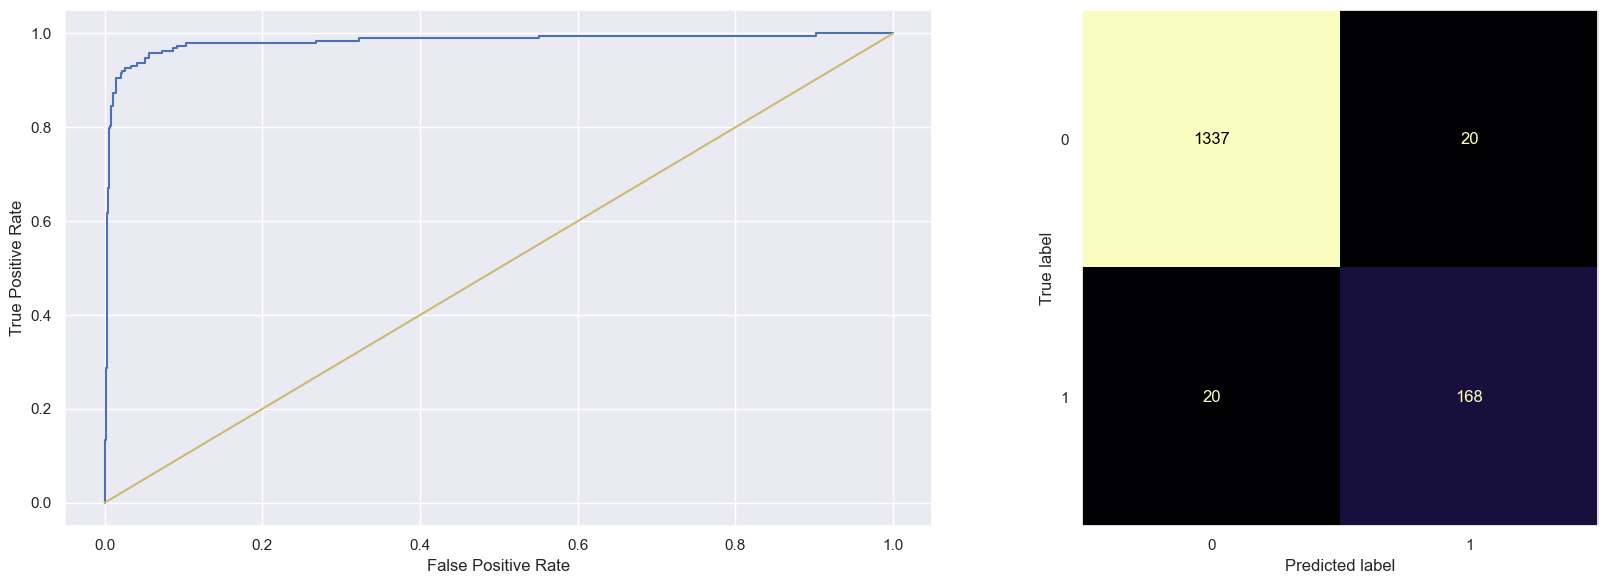

Recall Score:  0.894
Precision:  0.894
F1-Score:  0.894
Accuracy Score:  0.974
AUC Score:  0.982
Running Time :  0.0 Mins
******************************
Model : NaiveBayes
______________________________


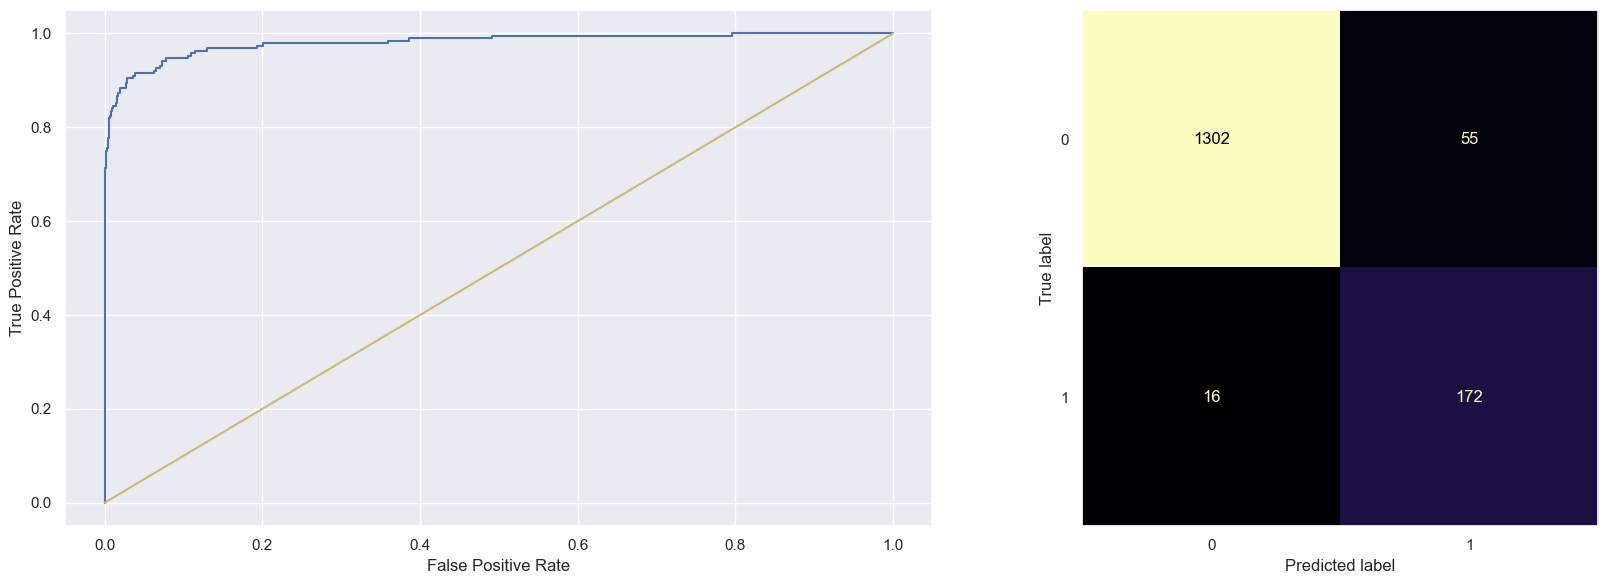

Recall Score:  0.915
Precision:  0.758
F1-Score:  0.829
Accuracy Score:  0.954
AUC Score:  0.98
Running Time :  0.0 Mins
******************************
Model : SVC
______________________________


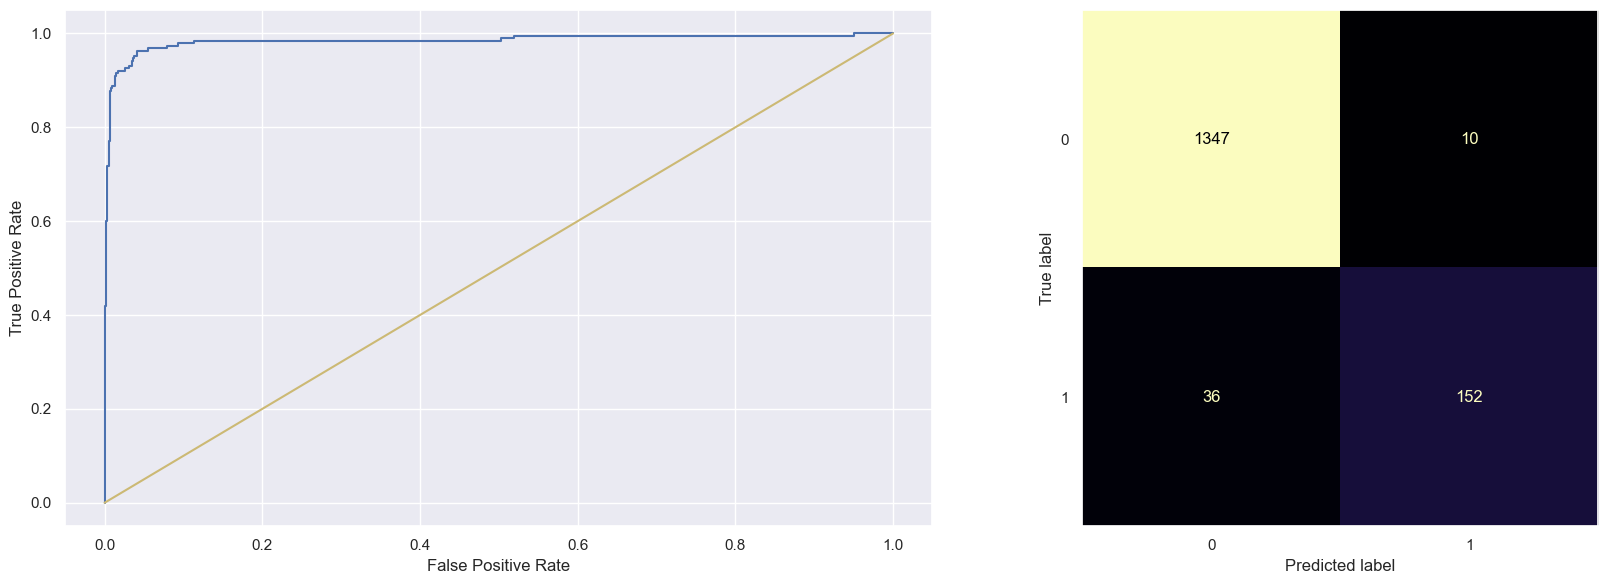

Recall Score:  0.809
Precision:  0.938
F1-Score:  0.869
Accuracy Score:  0.97
AUC Score:  0.984
Running Time :  0.14 Mins
******************************


In [51]:
evl_model(x_train,y_train,x_test,y_test)

## Recommendation
- **LogisticRegression and SVC** Have a good moderate scores for both a recall and precision so we can choose one of them
- **Naive Bayes** Has a good score for recall score, if our goal to detect as much as possible for a spam mails (Regardless the number of actual mails that the model predict it as spam) it will be the best solution